In [2]:
import pandas as pd 
import datetime
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler


import torch.nn as nn
import torch

import analysis_tools

import pickle

from sklearn.preprocessing import StandardScaler





font = {'family' : 'Tahoma',
        'size'   : 12}
mpl.rc('font', **font) 
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['black', 'r', 'g', 'y'])

mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10)



## Temperature Forecasting for Hamburg

We will create a model with the purpose of predicting the temperature in Hamburg, based on the temperatures of the previous days. First, we read in the data, of a weather data set which we found on Kaggle. It provides for lots of cities time series measurements on weather data. 

In [3]:
data_path = 'global-daily-climate-data/'

cities_path = data_path + 'cities.csv'
countries_path = data_path + 'countries.csv'
weather_data_path = data_path + 'daily_weather.parquet'

weather_data = pd.read_parquet(weather_data_path)

weather_data.head()



,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN


As you seen in the head of the data set above, not for all cities is data available for all parameters. For Asadabad for example, we only have the temperatures and the precipitation available. We will choose to make a weather prediction model for a city which has all data for all different parameters. The more data, the easier our life. 

Therefore, we will remove all rows which have a parameter for which there is no data available. 
Then, we will check the number of time serie data points available for each city. 


In [4]:
weather_data.dropna(inplace = True)
weather_data['city_name'].value_counts().head(10)


city_name
Hamburg       20629
Potsdam       19067
Bremen        19038
Hanover       18172
Magdeburg     17889
Erfurt        17358
Schwerin      17329
Düsseldorf    16962
Frauenfeld    16849
Malmö         14664
Name: count, dtype: int64

Hamburg as more than 20000 data points! That means 20000 days of temperature measurements, 200000 days of rain fall measurements etcetera! Thanks to modern weather measureming systems, these are a lot of measurements! Let's see if it will be enough to make a model to predict the temperature of Hamburg. 

We select the data of Hamburg and perform some modifications to the data. First, we convert the column with the data to a pandas datatime format. This will be usefull for plotting etc. Then, we add a column to the data that will indicate the month that we are dealing with. (why month, and not year/ day?). We will also remove the columns that we don't need; the city name and the station id. 

In [5]:
hamburg_data = weather_data.loc[weather_data['city_name'] == 'Hamburg']
hamburg_data.head()

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
21914,10147,Hamburg,1951-01-01,Winter,-2.0,-10.6,1.0,1.6,20.0,149.0,17.6,44.6,995.5,0.0
21915,10147,Hamburg,1951-01-02,Winter,-0.5,-2.9,0.6,3.8,50.0,137.0,19.4,44.3,993.4,0.0
21916,10147,Hamburg,1951-01-03,Winter,-0.1,-1.6,1.1,0.0,100.0,174.0,8.6,34.9,1002.6,0.0
21917,10147,Hamburg,1951-01-04,Winter,1.3,-0.5,2.5,1.5,80.0,208.0,22.7,50.0,1012.2,72.0
21918,10147,Hamburg,1951-01-05,Winter,4.3,0.9,6.0,6.1,20.0,210.0,25.2,56.5,1006.7,0.0


In [6]:
#we set the data as the index 
hamburg_data.loc[:, 'date'] = pd.to_datetime(hamburg_data['date'])
hamburg_data.set_index('date')

#we make a seperate column with month. this will be used as an input for the network
hamburg_data.loc[:, 'month'] = hamburg_data['date'].dt.month
hamburg_data.loc[:, 'day'] = hamburg_data['date'].dt.day


#remove the city column. 
hamburg_data = hamburg_data.drop(columns = ['city_name'])
hamburg_data = hamburg_data.drop(columns = ['station_id'])

/var/folders/zf/6v5q3x1x6rxd5grqb2fp2h3h0000gn/T/ipykernel_7253/1064623564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamburg_data.loc[:, 'month'] = hamburg_data['date'].dt.month
/var/folders/zf/6v5q3x1x6rxd5grqb2fp2h3h0000gn/T/ipykernel_7253/1064623564.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamburg_data.loc[:, 'day'] = hamburg_data['date'].dt.day


If we plot the data of the last 10 years, we see a nice seasonal variance of the temperature. So far so good! 

Text(0, 0.5, 'avg T')

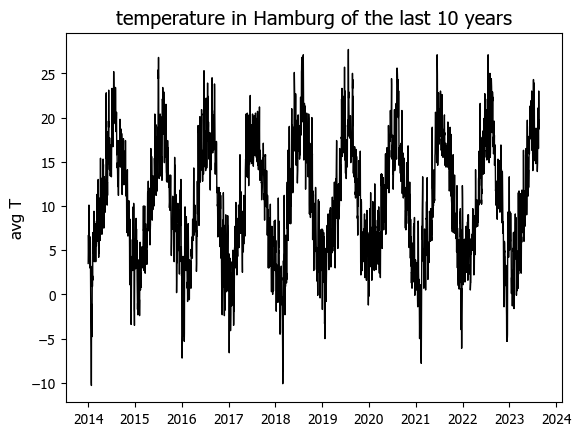

In [7]:
mask = (hamburg_data['date']) >= '2014-01-01'
plt.plot(hamburg_data['date'].loc[mask], hamburg_data['avg_temp_c'].loc[mask])
plt.title("temperature in Hamburg of the last 10 years")
plt.ylabel("avg T")

We do the final preparations before we can feed our data to the model. We remove the date from the data set. We added the month to the data set to indicate the timing. We don't need the date anymore. 
Then, we one-hot-encode the season. Now it is indicated as a string, which will not be approved by our model. Therefore, we add four columns, for each season one to indicate the season of the specific data point. 

In [8]:
# extract date column for later plotting use 
hamburg_dates = hamburg_data['date']
# remove date column from input data 
hamburg_data = hamburg_data.drop(columns = ['date'])

# we need to one-hot-encode the season column 
hamburg_LSTM = hamburg_data.copy(deep=True)
hamburg_LSTM = pd.get_dummies(hamburg_data, columns = ['season'])

hamburg_LSTM.head(5)

,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min,month,day,season_Autumn,season_Spring,season_Summer,season_Winter
21914,-2.0,-10.6,1.0,1.6,20.0,149.0,17.6,44.6,995.5,0.0,1,1,False,False,False,True
21915,-0.5,-2.9,0.6,3.8,50.0,137.0,19.4,44.3,993.4,0.0,1,2,False,False,False,True
21916,-0.1,-1.6,1.1,0.0,100.0,174.0,8.6,34.9,1002.6,0.0,1,3,False,False,False,True
21917,1.3,-0.5,2.5,1.5,80.0,208.0,22.7,50.0,1012.2,72.0,1,4,False,False,False,True
21918,4.3,0.9,6.0,6.1,20.0,210.0,25.2,56.5,1006.7,0.0,1,5,False,False,False,True


We cleaned up our data. Now it is time to reshape the data in the way our model likes. 
The goal of the model needs to be to predict the temperature at time $t$, knowing the data at the days before. We call the number of days that the data is known $T$. So; knowing the data of the last $T$ days, what is the weather at day $t$? 

Therefore, we feed the data of all parameters of $T$ days before day $t$, and label it with the temperature at day $t$. 
The input of our LSTM model needs to be of the shape\ $N$ by $T$ by $D$ where

$N$: the batch size \
$L$: the number of days before $t$ we know the data from\
$D$: the number of weather parameters\

Since we want to make a model to predict the average temparature, we feed the average temperature at time $t$ as a label to the model for the data of $t- T -1$ to $t - 1$



In [35]:
#shaping training and testing data set in desired shapes 
targets = hamburg_LSTM['avg_temp_c'].values
D = hamburg_LSTM.shape[1] #number of columns 
T = 28 #number of time steps  
pred_days = 7

#We take 80% of the data for the training set 
train_size = int(len(hamburg_LSTM) * 0.80)
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, pred_days))

# Normalizing the data 
scaler = StandardScaler()
scaler.fit(hamburg_LSTM[:train_size + T - 1])
hamburg_LSTM_norm = scaler.transform(hamburg_LSTM)

# Setting up matrices for x_train and y_train
for t in range(train_size):
  X_train[t, :, :] = hamburg_LSTM_norm[t:t+T]
  y_train[t] = (targets[(t+T):(t+T+pred_days)]) 

# Setting up matrices for X_test and y_test 
test_size =  len(targets) - T - train_size - pred_days
X_test = np.zeros((test_size, T, D))
y_test = np.zeros((test_size, pred_days))

for i in range(test_size):
  t = i + train_size
  X_test[i, :, :] = hamburg_LSTM_norm[t:t+T]
  y_test[i] = (targets[(t+T):(t+T+pred_days)]) 


We prepared our data! Now we can create a dataset and a dataloader and train our LSTM model. 

In [42]:

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data, labels):

        self.data = torch.from_numpy(data).type(torch.float32)
        self.labels = torch.from_numpy(labels).type(torch.float32)

    def __getitem__(self, i):
        data = self.data[i]
        label = self.labels[i]
        return data, label

    def __len__(self):
        return len(self.labels)
    

batch_size = 100
data_train = MyDataset(X_train, y_train )
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True)

data_test = MyDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, shuffle = False)



In [43]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.lstm = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)

    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M)
    c0 = torch.zeros(self.L, X.size(0), self.M)

    out, (hn, cn) = self.lstm(X, (h0.detach(), c0.detach()))

    # read out the final step 
    out = self.fc(out[:, -1, :])
    return out

In [193]:


model = LSTM(
     input_dim = D,#number of columns
     hidden_dim = 256, 
     layer_dim = 2, 
     output_dim = pred_days,
 )

model.load_state_dict(torch.load('hamburg_lstm.pth'))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

early_stopping = analysis_tools.EarlyStopping(patience=5, delta=0.01)

test_loss = []
train_loss = []

# Training 
for epoch in range(num_epochs):  
    
    train_accuracy = 0 
    model.train()
    train_loss_tmp = 0 
    total_samples = 0

    total = len(train_dataloader)
    for i, inputs in enumerate(train_dataloader):
        # Set gradients to zero 
        optimizer.zero_grad()

        # Forward pass
        x, labels = inputs
        y = model(x)
        loss = criterion(y, labels) 

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate losses
        train_loss_tmp += criterion(y, labels).item() * labels.size(0)
        total_samples += labels.size(0)
        if (i+1) % int(len(train_dataloader)/3) == 0:
         print(f"progress of {np.round((i+1)/(len(train_dataloader))*100, 0)}% for epoch {epoch+1}/{num_epochs}")
      
    train_loss_tmp /= len(train_dataloader.dataset)
    train_loss.append(train_loss_tmp)
        
    # Testing
    test_loss_tmp = 0 
    total_samples = 0

    model.eval() 

    with torch.no_grad():
        for inputs in test_dataloader:
            x, labels = inputs
            y = model(x)

            test_loss_tmp += criterion(y, labels).item() * labels.size(0)
            total_samples += labels.size(0)

    test_loss_tmp /= total_samples 
    test_loss.append(test_loss_tmp)
    
    print(f'Epoch {epoch+1}, Training Loss: {train_loss_tmp:.4f}, Validation Loss: {test_loss_tmp:.4f}')

    early_stopping.check(test_loss_tmp, model)#based on the losses 
    if early_stopping.early_stop:
        print(f"The training of the model is stopped after {epoch+1} epochs, to prevent overfitting...")
        break




/var/folders/zf/6v5q3x1x6rxd5grqb2fp2h3h0000gn/T/ipykernel_7253/434219496.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('hamburg_lstm.

progress of 33.0% for epoch 1/2
progress of 66.0% for epoch 1/2
progress of 99.0% for epoch 1/2
Epoch 1, Training Loss: 6.7595, Validation Loss: 11.6906
progress of 33.0% for epoch 2/2
progress of 66.0% for epoch 2/2
progress of 99.0% for epoch 2/2
Epoch 2, Training Loss: 5.8868, Validation Loss: 12.8653


In [194]:

#losses = {'train_loss': train_loss, 'test_loss':test_loss}

#with open('losses.pickle', 'wb') as handle:
#        pickle.dump(losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

#torch.save(model.state_dict(), 'hamburg_lstm.pth') #store new model parameters


save = True
if save:



    torch.save(model.state_dict(), 'hamburg_lstm.pth') #store new model parameters


    #store losses 
    with open('losses.pickle', 'rb') as handle:
        losses = pickle.load(handle)
    

    new_losses = {}
    tmp = losses['train_loss']
    new_losses['train_loss'] = tmp + train_loss
    tmp = losses['test_loss']
    new_losses['test_loss'] = tmp + test_loss 



    with open('losses.pickle', 'wb') as handle:
        pickle.dump(new_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)




I stored the losses in a seperate file, such that we can train our model more and more everytime we run it. When we look at the losses, we can see that the model is nicely describing the training and the validation data set. Or at least, better and better. 

## Plotting the losses 

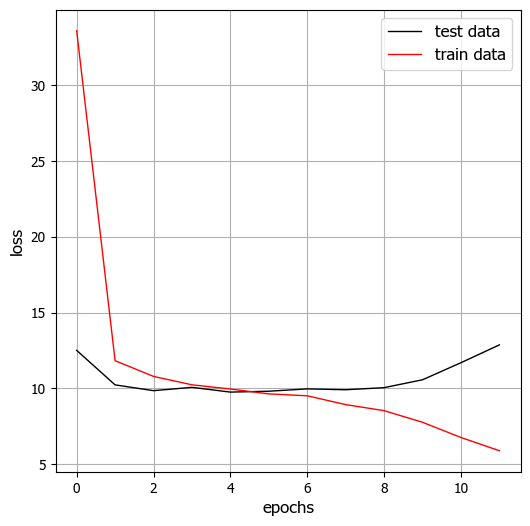

In [195]:
with open('losses.pickle', 'rb') as handle:
        losses = pickle.load(handle)
train_losses = losses['train_loss']
test_losses = losses['test_loss']

epochs = range(len(train_losses))
fig, axs = plt.subplots(1,1, figsize =(6,6))
axs.plot(epochs,test_losses, label = 'test data' )
axs.plot(epochs, train_losses, label = 'train data')
#axs.set_ylim(0, max(test_loss))
axs.set_ylabel("loss")
axs.legend()
axs.set_xlabel("epochs")
axs.grid()

## Plot model performance for 1 day forecasting

To know how well our model is working, we can compare the difference between the temperatures that the model predicts, with the actual temperatures. To quantify this, we can calculate the RMS value; the root of the mean of the squared differences. 

We will compare the results with a more naive model; the temperature at each day is the average of the temperatures on that exact day in the year for our complete data set. If we compare the RMS for this model, we see that our trained model is performing much better! That's great! We did not go thru the hussle of training our LSTM network for nothiing. 


In [196]:

model = LSTM(
     input_dim = D,
     hidden_dim = 256, 
     layer_dim = 2, 
     output_dim = pred_days,
 )

model.load_state_dict(torch.load('hamburg_lstm.pth'))



/var/folders/zf/6v5q3x1x6rxd5grqb2fp2h3h0000gn/T/ipykernel_7253/1471953674.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('hamburg_lstm

<All keys matched successfully>

In [197]:
# calculate the expected temperature values with our trained model for the test set 

results = []
true_values = []
model.eval()

for i in range(X_test.shape[0]):
    x = torch.from_numpy(X_test[i, :, :].reshape(1, T, D)).type(torch.float32)
    y = model(x) 
    y = y.detach().numpy()[0] #get first value 
    results.append(y)

    true_values.append(hamburg_LSTM['avg_temp_c'].values[train_size+T+i:train_size+i+T+7])




In [198]:
results = np.array(results).reshape(len(results), pred_days)
true_values = np.array(true_values).reshape(len(true_values), pred_days)

In [202]:

#for each date in the test range, compute the average of all the data 
estimates = []
for date in hamburg_dates[train_size+T:-pred_days]:
    dag = date.day
    month = date.month
    mask = ((hamburg_LSTM['day'] == dag)&(hamburg_LSTM['month'] == month))
    estimate = hamburg_LSTM.loc[mask]['avg_temp_c'].mean()
    estimates.append(estimate)

The RMS error for the trained model is 2.46
The RMS error for the naive model is 3.44


(17167.0, 18262.0)

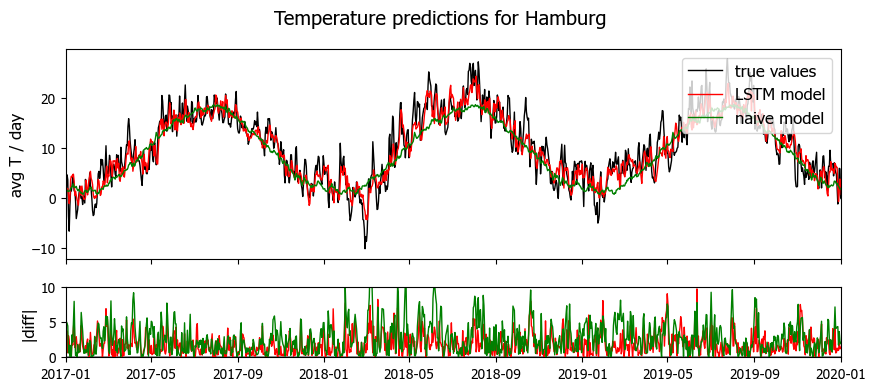

In [211]:
# plot the data and the model predictions 

fig, axs = plt.subplots(2,1, height_ratios=[3, 1], figsize = (10, 4), sharex=True)
fig.suptitle("Temperature predictions for Hamburg")


axs[0].plot(hamburg_dates[train_size+T:-pred_days], hamburg_LSTM['avg_temp_c'][train_size+T:-pred_days], label = 'true values')
axs[0].plot(hamburg_dates[train_size+T:-pred_days], results[:, 0], label = 'LSTM model')
axs[0].plot(hamburg_dates[train_size+T:-pred_days], estimates, label = 'naive model')
axs[0].set_ylabel("avg T / day")
axs[0].legend(loc = 1)

diff_lstm = hamburg_LSTM['avg_temp_c'][len(X_train)+T:-pred_days] - results[:, 0]
rms_lstm = np.sqrt(np.mean((diff_lstm)**2))

print(f"The RMS error for the trained model is {rms_lstm:.2f}")


diff_naive = hamburg_LSTM['avg_temp_c'][len(X_train)+T:-pred_days] - estimates
rms_naive = np.sqrt(np.mean((diff_naive)**2))

print(f"The RMS error for the naive model is {rms_naive:.2f}")

axs[1].plot(hamburg_dates[-len(X_test):], np.zeros(len(hamburg_dates[-len(X_test):])), label = 'true values')
axs[1].plot(hamburg_dates[-len(X_test):], abs(diff_lstm), label = 'LSTM model')
axs[1].plot(hamburg_dates[-len(X_test):], abs(diff_naive), label = 'naive model')
axs[1].set_ylabel("|diff|")
axs[1].set_ylim((0, 10))
axs[1].set_xlim([datetime.date(2017, 1, 1), datetime.date(2020, 1, 1)])







## Performance for week prediction 

In [206]:
#plotting example for one week prediction
rms = []

for i in range(pred_days):
    rms_i = np.sqrt(np.mean(results[:, i] - true_values[:, i])**2)
    rms.append(rms_i)


    

Text(0, 0.5, 'RMS error')

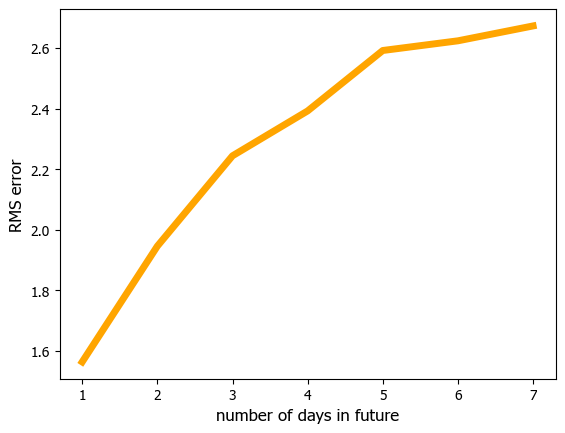

In [212]:
plt.plot(np.arange(pred_days)+1, q_median, color = 'orange', lw = 5)
#plt.fill_between(np.arange(pred_days)+1, q_lower, y2 = q_upper, alpha = .4, color = 'orange')
plt.xlabel("number of days in future")
plt.ylabel("RMS error")